## Vector AutoRegression

This class inherets from Base_Analysis_Class and provides some simple functionality for: 
    1. Checking stationarity of (multiple) time-series
    
    2. Plotting timeline, lag-plot, autocorrelation plot (you need to be on ipython environment)
    
    3. Creating and fitting VAR model based on the dataframe (index=time variable) provided from the 'timeline' class. Here, you can speicfy:
        - N-lags /ByDefault statsmodels chooses the most apporporate lag for you based on Ljung-Box             Q-score. 
        
    

bobber = poplvok :)

In [2]:
# Blueprint of the class VAR 
#requirements: 
import pandas as pd
import numpy as np
from core.analysis_base_class import Analysis
from analysis import timeline_analysis as ta
from statsmodels.tsa.api import VAR as var 
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.tsatools import detrend
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf


class VAR(Analysis):
    """ When creating var model we first generate a timeline in the form of pandas df. Then feed it to VAR method in statsmodels.
        We can save the names of the variables(queries) this way so no need of mapping (var to name) on the later stages,
        awesome plotting functionality and just comfortable to work with for everyone. 
    """
    
    def __init__(self,queries,timefield,granularity, querytype="count"):
        """ @queries  = what do you want to query from ES ? eg queries = ['de','het']
            @timefield = what field do you want to use to get the dates/timeline from ? 'META.ADDED'
            @ granularity = 'day'/'week'/'month' etc 
            
            We need a nice dataframe with (index=time & cols=queries) to work further - so lets create it here 
        """
        timeline = ta.timeline_generator()
        df_raw = timeline.analyse(queries=queries,timefield = timefield, granularity = granularity)
        df_raw.index = df_raw.timestamp
        df_raw = df_raw.drop('timestamp',axis=1)
        # by default the timeline is made balanced ...
        # check for issues with series at this step ? 
        self.df = df_raw
        self.temp = 0.0   ##
          

    def test_assumptions(self,level = '5%',**kwargs):
        """ 
        Gives you output as list with assumptions stated as satisfied/not satisfied. If some important 
        assumptions are not satisfied gives you warning that you have to transform your data. 
        
        @level -  this is the level you are testing your asusmptions on (either 1,5 or 10 %)
        """
        self.level =  level
        df = self.df          ## 
        
        
        
        def _adf_test(df):
            """ 
            H_0: the observed time series is stationary 
            Returns: dataframe of summary of the test 
            """
            summary_adf = pd.DataFrame(columns=['ADF_Stat','p-value','Critical_val_1%','Critical_val_5%','Critical_val_10%'])
            for name in df.columns:
                series = df[name]
                result = adfuller(series)
                dic = {'ADF_Stat':result[0],'p-value':result[1],'Critical_val_1%':result[4]['1%'],'Critical_val_5%':result[4]['5%'],
                       'Critical_val_10%':result[4]['10%']}
                summary_adf = summary_adf.append(dic,ignore_index=True)
            summary_adf.set_index(df.columns,inplace=True)  

            return summary_adf 
    
        def _kpss_test(df):
            """ 
            H_0: there is a unit root in time series, hence stochastic trend with drift, hence non-stationary
            Returns: dataframe of summary of the test
            """
            summary_kpss = pd.DataFrame(columns=['KPSS_Stat','p-value','Critical_val_1%','Critical_val_5%','Critical_val_10%'])
            for name in df.columns:
                series = df[name]
                result = kpss(series)
                dic = {'KPSS_Stat':result[0],'p-value':result[1],'Critical_val_1%':result[3]['1%'],'Critical_val_5%':result[3]['5%'],
                       'Critical_val_10%':result[3]['10%']}
                summary_kpss = summary_kpss.append(dic,ignore_index=True)
            summary_kpss.set_index(df.columns,inplace=True)  

            return summary_kpss
        
        
        def _stationary(df, explicit=True):
            """ 
            For each time series return the result of the check - return in created dataframe ?
            """
            lvl = float(self.level[:-1])/100 
            self.summary_adf = _adf_test(df)
            self.summary_kpss = _kpss_test(df)
             
            stat_flag = True       ## if one of the test failed, we assume we need to take action 
            if explicit:
                for i in df.columns:
                    adf_flag = lvl > self.summary_adf.loc[i,'p-value']
                    kpss_flag = lvl < self.summary_kpss.loc[i,'p-value']
                    if ((adf_flag == False) | (kpss_flag == False)):
                        stat_flag = False 
                    print("For {} stationarity is satisfied: ADF - {} | KPSS - {} ".format(i,adf_flag, kpss_flag)) # PRINT  (!)
                    
            return stat_flag   
        
        def differencing(on=df, order=1):
            """ If there is no stationarity: try differencing
            """             
            def _perform_differencing():
            # Perform differencing:  
                df_diff = pd.DataFrame(columns=df.columns)
                for name in df.columns:
                    series = df[name]
                    series = series.diff(order)
                    df_diff[name] = series.dropna(axis=0)
                
                return _stationary(df_diff)   
            
            stat_check_after_diff = _perform_differencing()
            print('Differencing helped?')   ##            
            print(stat_check_after_diff)   ##
            
            ## if differencing helped update self.df => self.df = df_diff 
            
            return ##
        
        def detrending(on=df, order=1):
            """ If there is no stationarity: differencing did not help - detrend
            
                (!) does not work nicely with time series where there is a lot of zeros and high volatility :(
            """             
            def _perform_detrending():
            # Perform detrending:  
                df_res = pd.DataFrame(columns=df.columns)
                for name in df.columns:
                    series = df[name]
                    res = detrend(series,order)
                    df_res[name] = series.dropna(axis=0)
                
                return _stationary(df_res)   
            
            stat_check_after_detrend = _perform_detrending()
            print('Detrending helped?')   ##            
            print(stat_check_after_detrend)   ##
            
            ## if differencing helped update self.df => self.df = df_diff 
            
            return ##
        
        
        stationarity_check = _stationary(df, explicit=True)  ## if false then one one or more of the series might be non-stat.
        ## if stat._check == False
        
        do_diff = differencing(df)
        do_detrend = detrending(df)
        return ##

    def fit(self,df, nlags=None):
        """
        This method creates a Vector AutoRegressive model to timeline dataframe
        @df - dataframe with columns representing queries (eg count number of documents 
               whcich mention a word or phrase) 
        @nlags -  number of lags to consider 
        """
        self.model = var(self.df)                           ## creating VAR model , could go to __init__
        self.result = self.model.fit()   
        #self.order = self.model.select_order(verbose=True)              ## this will automatically detect the best lag
        #print(self.order['bic'])                                        ##selects lag based on infomation criteria
        
        return #0.0 #self.result.summary()###

    def forecast(self,d = 5):
        """
        Makes forecasts based on the parameters of fitted model 
        @ d - how many steps into the future you want to forecast 
        """
        prediction_array= self.result.forecast(self.df.values,d)
        
        predictions = pd.DataFrame(prediction_array, columns= self.df.columns)
        print(predictions)     ###
        return ## 


    def interpretation(self, **kwargs):
        """
        This method should have the functionality to interpret the status of the model after being trained and also document the various design choices\
        (i.e. parameters settings, assumptions, model selection, test method, dataset used). For example it can return a report-like looking formatted string.\n
        Please consider the following as possible model state interpretation:\n
           * For classification tasks depending on the underlying model: coeficient/feature weights, feature selection (random forest)\n
           * For clustering tasks: clusterings members/structure, distributions
        """
        raise NotImplementedError

    def diagnostics(self):
        """
        This method should have the functionality to report on the quality of the underlying (trained) model used for 
        the analysis (on a dataset)
           
        Common diagnostics for VAR: check noramlity of residuals
        """
        residuals = self.result.resid
        print(residuals)
        return ##

    def plot(self, plot_type=None, lag = 1):
        """
        To be able to see the results this method requires an ipython environment run
        """
        def lag_scatter():
            for name in self.df.columns:
                series = self.df[name]
                print("Lag plot where y is {}".format(name))
                lag_plot(series,lag)
                pyplot.show()    

            return ##
        
        def line_plot():
            for name in self.df.columns:
                series = self.df[name]
                series.plot(legend=True)
            pyplot.show()
            return ##
    
        def autocorrelation_plot():
            for name in self.df.columns:
                series = self.df[name]
                print("Autocorelation plot for {}".format(name))
                plot_acf(series, lags=lag)
                pyplot.show()
            
        if plot_type == None:
            lag_scatter() 
            line_plot()
            autocorrelation_plot()
        if (plot_type == ('line')):
            line_plot()
        if (plot_type == ('lag')):
            lag_scatter()
        if (plot_type == ('autocorrelation')):
            autocorrelation_plot()
        
        return ## 

No database functionality available


no mapping exists!or smth went wrong


C:\Users\HP\Anaconda2\envs\inca362\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [27]:
d = input()

43


## Testing the class

In [1]:
import numpy as np 
import pandas as pd

In [48]:
m1 = VAR(queries=['de','het'], timefield = 'META.ADDED', granularity = 'day')

In [53]:
m1.df

,1. de,2. het
timestamp,,
2017-11-02T00:00:00.000Z,10,10
2017-11-03T00:00:00.000Z,19,19
2017-11-04T00:00:00.000Z,0,0
2017-11-05T00:00:00.000Z,0,0
2017-11-06T00:00:00.000Z,199,198
2017-11-07T00:00:00.000Z,0,0
2017-11-08T00:00:00.000Z,143,143
2017-11-09T00:00:00.000Z,0,0
2017-11-10T00:00:00.000Z,0,0


In [54]:
m1.test_assumptions('1%')

For 1. de    stationarity is satisfied: ADF - True | KPSS - True 
For 2. het    stationarity is satisfied: ADF - True | KPSS - True 
For 1. de    stationarity is satisfied: ADF - True | KPSS - True 
For 2. het    stationarity is satisfied: ADF - True | KPSS - True 
Differencing helped?
True
For 1. de    stationarity is satisfied: ADF - True | KPSS - True 
For 2. het    stationarity is satisfied: ADF - True | KPSS - True 
Detrending helped?
True


C:\Users\HP\Anaconda2\envs\inca362\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [164]:
m1.fit()
m1.forecast()
m1.plot(plot_type = 'autocorrelation' ,lag = 2)
#m1.diagnostics()

In [161]:
# generate two arbitrary sample to work with, put them in df, add time trend
sample1 = np.random.gamma(4,3,50)
sample2 = np.random.binomial(10,0.7,size=50)

# create a pandas dataframe with counts of mentions of a particular word (two arrays)
df = pd.DataFrame({'x':sample1, 'y':sample2})
df['t'] = df.index
df['x'] = df.x.astype('int')
df = df.drop(['t'],axis=1)

#make index a date object
import datetime
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(0, 50)]

df.index = date_list

For 1. de    stationarity is satisfied: ADF - True | KPSS - True 
For 2. het    stationarity is satisfied: ADF - True | KPSS - True 
    1. de     2. het   
0  15.798323  15.755806
1  15.421291  15.379729
2  15.462262  15.420584
3  15.457916  15.416251
4  15.458378  15.416711
Autocorelation plot for 1. de   


C:\Users\HP\Anaconda2\envs\inca362\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


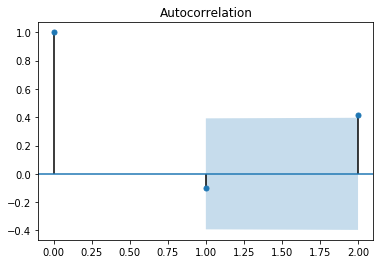

Autocorelation plot for 2. het   


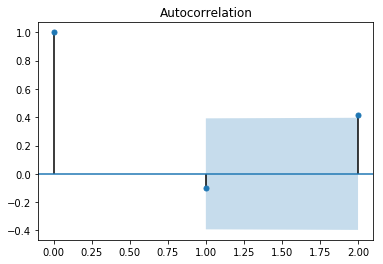

,x,y
2017-11-15 12:57:19.273678,3,9
2017-11-14 12:57:19.273678,13,6
2017-11-13 12:57:19.273678,8,9
2017-11-12 12:57:19.273678,8,10
2017-11-11 12:57:19.273678,11,7
2017-11-10 12:57:19.273678,11,6
2017-11-09 12:57:19.273678,6,7
2017-11-08 12:57:19.273678,20,7
2017-11-07 12:57:19.273678,10,8
2017-11-06 12:57:19.273678,7,10
